## In this notebook, I will be preprocessing data and training model to predict Type 1 diabetes risk for 23andme users

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [28]:
# load datasets
df = pd.read_csv('data/efotraits_EFO_0001359-associations-2021-06-18.csv')

# process dataset 
cols_to_keep = ['Variant and risk allele', 'RAF', 'Beta']
df = df.drop(df.columns.difference(cols_to_keep), axis=1)
df = df.replace('NR',np.nan)
df = df.replace("'-",np.nan)
df = df.dropna()

df = df.rename(columns = {'Variant and risk allele':'id','RAF':'raf', 'Beta':'beta'})

df['allele'] = df['id'].str.split("<b>", 1, expand=True)[1].str[0]
df['id'] = df['id'].str.split("-", 1, expand=True)
df['beta'] = df['beta'].str.split(" ", 1, expand=True)

df = df.replace("?",np.nan)
df = df.dropna()

df['raf'] = df['raf'].astype(float)
df['beta'] = df['beta'].astype(float)

# save dataframe to csv
df.to_csv('data/EFO_0001359.csv')

In [29]:
user_data_1 = pd.read_csv('example1.txt', sep='\t', dtype={'rsid':'str', 'chromosome':'object', 'position':'int', 'genotype':'str'}, comment='#', names = ['rsid', 'chromosome', 'position', 'genotype'])
user_snps_1 = user_data_1['rsid'].tolist()
print(len(user_snps_1))

631955


In [30]:
data_snps = df['id'].tolist()
row_to_keep = list(set(user_snps_1) & set(data_snps))
print(row_to_keep)
print(len(row_to_keep))

['rs116763857', 'rs3093664', 'rs74203920', 'rs1493696', 'rs3128930', 'rs1050979', 'rs3135365', 'rs35122968', 'rs45626136', 'rs241427', 'rs78824139', 'rs116020851', 'rs4148870']
13


In [31]:
df = df[df['id'].isin(row_to_keep)]

In [32]:
mapping = {}
for _, row in df.iterrows():
    if row['id'] not in mapping:
        mapping[row['id']] = [row['allele']]
    else:
        if row['allele'] not in mapping[row['id']]:
            mapping[row['id']].append(row['allele'])


In [33]:
print(mapping)

{'rs1493696': ['A'], 'rs1050979': ['G'], 'rs74203920': ['T'], 'rs78824139': ['C'], 'rs116020851': ['C'], 'rs45626136': ['C'], 'rs116763857': ['G'], 'rs3093664': ['G'], 'rs3135365': ['C'], 'rs35122968': ['C'], 'rs241427': ['G'], 'rs4148870': ['C'], 'rs3128930': ['C']}


## Simulate data

In [34]:
cols_to_keep = ['id', 'raf', 'beta']
df = df.drop(df.columns.difference(cols_to_keep), axis=1)
df = df.drop_duplicates(subset=['id'])

In [35]:
# risk labels, 0=low, 1=medium, 2=high
risk_labels = [0, 1, 2]

# proportion/probability of each risk (the lower the risk the more common)
risk_prob = [0.55, 0.35, 0.1]

# varying probabilities of having SNPs
low_risk_bias = np.arange(0, 0.75, 0.05)
medium_risk_bias = np.arange(0.75, 0.9, 0.05)
high_risk_bias = np.arange(0.9, 1, 0.05)
risk_bias = [low_risk_bias, medium_risk_bias, high_risk_bias]

In [36]:
# simulate 10,000 individuals
individuals = []
labels = []
for _ in range(10000):
    label = np.random.choice(a=risk_labels, p=risk_prob)
    bias = np.random.choice(risk_bias[label])
    snps = (df['raf'].apply(lambda x: np.random.choice(a=[0,1], p=[1-(x*bias), x*bias])))
    individuals.append(snps.values)  
    labels.append(label)

In [37]:
simulated_df = pd.DataFrame(individuals, columns=df['id'])
simulated_df.columns.name = 'n'

In [38]:
# add polygenic risk score for each individual
beta_dict = df.set_index('id')['beta'].to_dict()
beta_values = np.array([beta_dict.get(x) for x in simulated_df.columns])
prs = simulated_df.apply(lambda x: (x*beta_values).sum(), axis=1)
simulated_df['prs'] = prs
simulated_df['label'] = labels

In [39]:
simulated_df
simulated_df.groupby('label')['prs'].mean()

label
0    0.271965
1    0.643433
2    0.721143
Name: prs, dtype: float64

Text(0, 0.5, 'Frequency')

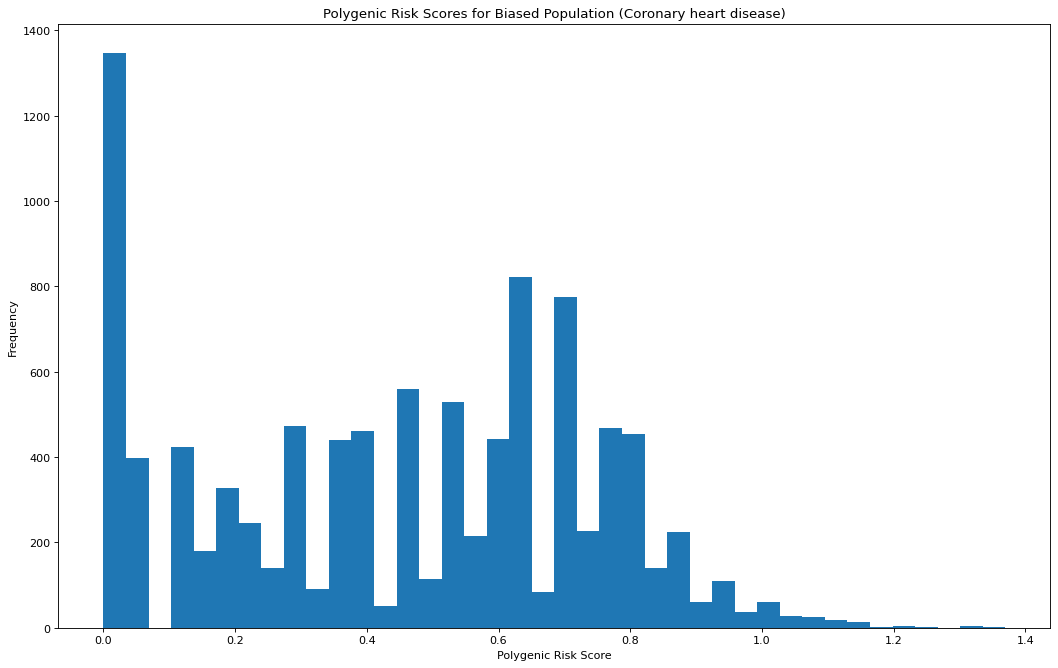

In [40]:
plt.figure(figsize=(16, 10), dpi=80)
plt.hist(simulated_df['prs'], 40)
plt.title("Polygenic Risk Scores for Biased Population (Coronary heart disease)")
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Frequency')

In [41]:
simulated_df.to_csv('data/diabetes_data.csv')

In [42]:
simulated_df

n,rs1493696,rs1050979,rs74203920,rs78824139,rs116020851,rs45626136,rs116763857,rs3093664,rs3135365,rs35122968,rs241427,rs4148870,rs3128930,prs,label
0,0,0,0,1,0,1,0,0,0,0,0,0,1,0.458000,0
1,0,0,0,1,0,1,0,0,0,0,1,1,0,0.520000,1
2,0,0,0,0,0,1,0,0,0,0,0,1,1,0.217000,0
3,0,1,0,1,1,1,0,0,0,0,1,1,0,0.808196,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,1,0,0,0.062000,0
9996,0,0,0,0,0,1,0,0,0,0,1,0,1,0.226000,0
9997,0,0,0,0,1,0,0,0,0,0,1,1,1,0.350000,1
9998,0,1,0,1,0,1,0,0,0,1,0,0,0,0.711196,0


## model training

In [43]:
df = pd.read_csv('data/diabetes_data.csv')

X = df.drop(['label','Unnamed: 0','prs'], axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 13)
(2000, 13)
(8000,)
(2000,)


In [45]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    labels = ['Low', 'Medium', 'High']
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s Risk' % (roc_auc[i], labels[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


In [46]:
from hyperopt import hp
from hyperopt import Trials
from hyperopt import fmin, tpe
from hyperopt import STATUS_OK

In [47]:
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 1,3),
        'learning_rate' : hp.quniform('learning_rate', 0.01,1,0.05),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 5, 1),
        'n_estimators': 100,
        'seed': 0
    }

In [48]:
def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    learning_rate = int(space['learning_rate']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    score = f1_score(y_test, pred, average='micro')
    return {'loss': -score, 'status': STATUS_OK }


In [49]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [00:06<00:00, 16.01it/s, best loss: -0.752]


In [50]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8223920379077532, 'gamma': 1.142719481160321, 'learning_rate': 1.0, 'max_depth': 9.0, 'min_child_weight': 1.0}


In [51]:
xgb_opt = XGBClassifier(n_estimators = 100,
                            max_depth = int(best_hyperparams['max_depth']),
                            learning_rate = best_hyperparams['learning_rate'],
                            gamma = best_hyperparams['gamma'],
                            min_child_weight = best_hyperparams['min_child_weight'],
                            colsample_bytree = best_hyperparams['colsample_bytree']
                            )
xgb_opt.fit(X_train, y_train)

[16:31:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8223920379077532,
              gamma=1.142719481160321, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1.0, max_delta_step=0,
              max_depth=9, min_child_weight=1.0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

    Low Risk       0.83      0.85      0.84      1132
 Medium Risk       0.62      0.73      0.67       693
   High Risk       0.41      0.04      0.07       175

    accuracy                           0.74      2000
   macro avg       0.62      0.54      0.53      2000
weighted avg       0.72      0.74      0.72      2000

auc score is:  0.8488911856050588


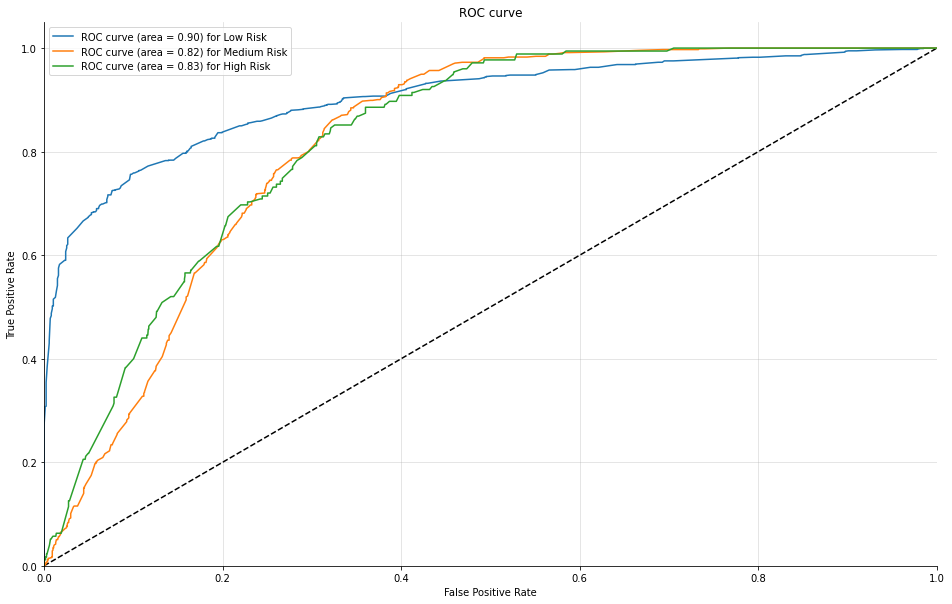

In [52]:
y_pred_xgb = xgb_opt.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, xgb_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(xgb_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

In [89]:
xgb_opt = XGBClassifier(learning_rate=0.15, reg_alpha=0.5)
xgb_opt.fit(X_train, y_train)

[12:14:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.5,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

    Low Risk       0.81      0.83      0.82      1081
 Medium Risk       0.60      0.65      0.62       722
   High Risk       0.50      0.29      0.37       197

    accuracy                           0.71      2000
   macro avg       0.64      0.59      0.60      2000
weighted avg       0.70      0.71      0.70      2000

auc score is:  0.8561712504344898


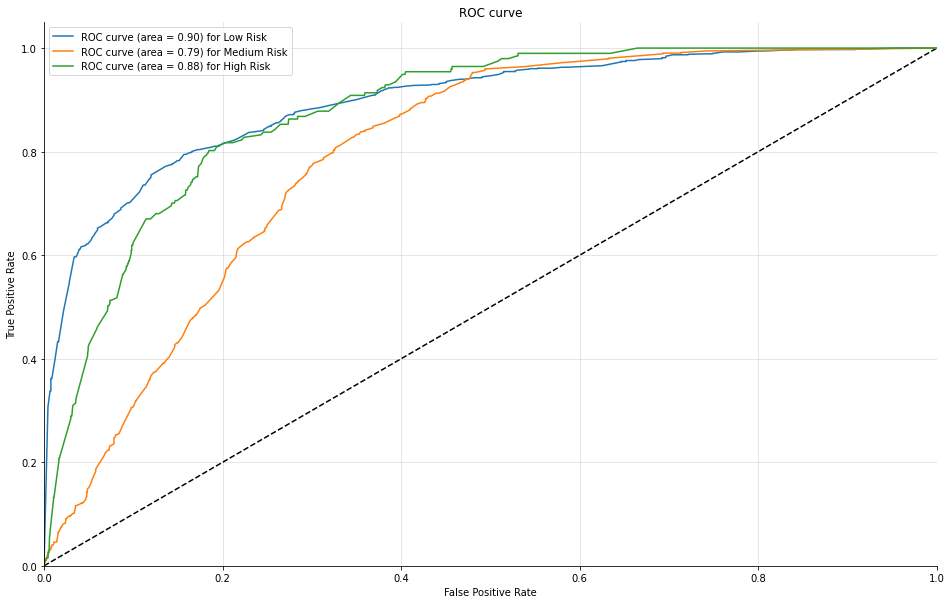

In [90]:
y_pred_xgb = xgb_opt.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=['Low Risk', 'Medium Risk', 'High Risk']))
auc_val = roc_auc_score(y_test, xgb_opt.predict_proba(X_test), multi_class='ovr')
print("auc score is: ", auc_val)
plot_multiclass_roc(xgb_opt, X_test, y_test, n_classes=3, figsize=(16, 10))

In [52]:
# from sklearn.externals import joblib
import joblib
  
# Save the model as a pickle in a file
joblib.dump(xgb_opt, 'diabetes-model.pkl')

['diabetes-model.pkl']